In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, nbinom
from scipy.special import gamma, gammaln

In [2]:
alpha= 50
gamma(2*alpha+1)/gamma(alpha)

1.5342593781274831e+95

In [3]:
np.exp(gammaln(2*alpha+1)-gammaln(alpha))

1.5342593781274813e+95

In [4]:
np.random.randint?

In [91]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data, partition

def generate_poisson_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        lamb = np.abs(np.random.randn())*5
        print(lamb)
        tdata = np.random.poisson(lamb, p)
        data = np.concatenate((data, tdata))
    return data, partition


In [119]:
#Read and plot data

DIR_FILENAME = 'dowj_1996-2018.csv'
#dataset = np.genfromtxt(DIR_FILENAME, delimiter=',')
dataset = np.genfromtxt('data/population.csv',delimiter=',')

dataset_n, part_n = generate_normal_time_series(8, 150, 200)
dataset_p, part_p = generate_poisson_time_series(3, 50, 70)

5.77733371208
5.6065775815
2.50820587669


In [108]:
dataset_n= dataset_n/np.sum(dataset_n)

In [128]:
#Define functions

def const_hazard(r,lambda_):
    probs = np.ones(r)/lambda_
    return probs

def pred_prob(x,mu,alpha,kappa,beta,mean,var,dist,typ):
    if dist=='norm':
        if typ=='both_unknown':
            prec = (alpha*kappa)/(beta*(kappa+1))
            df = 2*alpha
            #pred= t.pdf(x, df=df,loc=mu,scale=np.sqrt(prec))
            #import pdb; pdb.set_trace()
            gamma_part = np.exp(gammaln(2*alpha+1)-gammaln(alpha))
            pred = gamma_part*(np.sqrt(prec/(np.pi*df))*((1+((x-mu)**2)/(df*(1/prec)))**(-1*(df+1)/2)))
        if typ == 'var_known':
            pred = norm.pdf(x, loc=mu,scale=kappa+var)
        if typ == 'mean_known':
            deg_freedom = 2*alpha
            precision = alpha/beta
            pred = t.pdf(x, df=deg_freedom,loc=mean,scale=np.sqrt(precision))
            
        
    if dist=='poisson':  
        gamma_part = gamma(x+alpha)/(gamma(alpha)*gamma(x+1))
        pred = gamma_part* ((beta/(beta+1))**alpha)*((1/(beta+1))**x)
        
    return pred

def update_stats(x,mu,alpha,kappa,beta,mean,var,dist,typ):
    if dist =='norm':
        if typ== 'both_unknown':
            mu, alpha, kappa, beta = (kappa*mu + x) / (kappa+1.), alpha+0.5, kappa+1., beta +((kappa*((x-mu)**2))/(2*(kappa+1.)))
        if typ == 'var_known':
            mu, kappa = mu, kappa
        if typ == 'mean_known':
            alpha,beta = alpha +0.5, beta+ 0.5*((x-mean)**2)
    if dist == 'poisson':
        alpha, beta = alpha + x , beta+1
    return mu, alpha, kappa, beta


In [131]:
def inference(data, mu0 = 0, kappa0 = 1, alpha0= 0.1, beta0= 0.1, lam = [200], dist='norm',typ='mean_known',mean=0,var=1):
    #Initialize
    prob_r = np.zeros((len(data) + 1, len(data) + 1))
    prob_r[0, 0] = 1
    mu, kappa, alpha, beta = np.array([mu0]), np.array([kappa0]), np.array([alpha0]), np.array([beta0])
    
    #Start iteration   
    for t,x in enumerate(data):      
        #Calculate predictive probability for new data point
        pred = pred_prob(x,mu,alpha,kappa,beta,mean,var,dist,typ)
        
        #Calculate growth probability 
        prob_r[1:t+2,t+1] = prob_r[:t+1,t]* pred * (1-const_hazard(t+1,lam))

        #Calculate changepoint probability
        prob_r[0,t+1] = np.sum( prob_r[:t+1,t] * pred * const_hazard(t+1,lam))
        
        #Calculate evidence
        sum_prob_r =  np.sum(prob_r[:,t+1])
        
        #Run length distribution
        prob_r[:,t+1] /= sum_prob_r
        
        #Update sufficient statistics
        mu_n, alpha_n, kappa_n, beta_n = update_stats(x, mu, alpha, kappa,beta,mean,var, dist,typ) 
        mu, kappa, alpha, beta = np.append(np.array([mu0]), mu_n), np.append(np.array([kappa0]), kappa_n), np.append(np.array([alpha0]), alpha_n), np.append(np.array([beta0]), beta_n) 
        print(alpha)
        
    return prob_r

In [132]:
p = inference(dataset_n,typ='both_unknown')

[ 0.1  0.6]
[ 0.1  0.6  1.1]
[ 0.1  0.6  1.1  1.6]
[ 0.1  0.6  1.1  1.6  2.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6  7.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6  7.1
  7.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6  7.1
  7.6  8.1]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6  7.1
  7.6  8.1  8.6]
[ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.1  4.6  5.1  5.6  6.1  6.6  7.1
  7.6  8.1  8.6  9.1]
[ 0.1  0.6  1.1

[  0.1   0.6   1.1   1.6   2.1   2.6   3.1   3.6   4.1   4.6   5.1   5.6
   6.1   6.6   7.1   7.6   8.1   8.6   9.1   9.6  10.1  10.6  11.1  11.6
  12.1  12.6  13.1  13.6  14.1  14.6  15.1  15.6  16.1  16.6  17.1  17.6
  18.1  18.6  19.1  19.6  20.1  20.6  21.1  21.6  22.1  22.6  23.1  23.6
  24.1  24.6  25.1  25.6  26.1  26.6  27.1  27.6  28.1  28.6  29.1  29.6
  30.1  30.6  31.1  31.6  32.1  32.6  33.1  33.6  34.1  34.6  35.1  35.6
  36.1  36.6  37.1  37.6  38.1  38.6  39.1  39.6  40.1  40.6  41.1  41.6
  42.1  42.6  43.1  43.6  44.1  44.6  45.1  45.6  46.1  46.6  47.1  47.6
  48.1  48.6  49.1  49.6  50.1  50.6  51.1  51.6  52.1  52.6  53.1  53.6
  54.1  54.6  55.1  55.6  56.1  56.6  57.1  57.6  58.1  58.6  59.1  59.6]
[  0.1   0.6   1.1   1.6   2.1   2.6   3.1   3.6   4.1   4.6   5.1   5.6
   6.1   6.6   7.1   7.6   8.1   8.6   9.1   9.6  10.1  10.6  11.1  11.6
  12.1  12.6  13.1  13.6  14.1  14.6  15.1  15.6  16.1  16.6  17.1  17.6
  18.1  18.6  19.1  19.6  20.1  20.6  21.1  21.6  

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

   1.30100000e+02   1.30600000e+02   1.31100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+0

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

[  1.00000000e-01   6.00000000e-01   1.10000000e+00   1.60000000e+00
   2.10000000e+00   2.60000000e+00   3.10000000e+00   3.60000000e+00
   4.10000000e+00   4.60000000e+00   5.10000000e+00   5.60000000e+00
   6.10000000e+00   6.60000000e+00   7.10000000e+00   7.60000000e+00
   8.10000000e+00   8.60000000e+00   9.10000000e+00   9.60000000e+00
   1.01000000e+01   1.06000000e+01   1.11000000e+01   1.16000000e+01
   1.21000000e+01   1.26000000e+01   1.31000000e+01   1.36000000e+01
   1.41000000e+01   1.46000000e+01   1.51000000e+01   1.56000000e+01
   1.61000000e+01   1.66000000e+01   1.71000000e+01   1.76000000e+01
   1.81000000e+01   1.86000000e+01   1.91000000e+01   1.96000000e+01
   2.01000000e+01   2.06000000e+01   2.11000000e+01   2.16000000e+01
   2.21000000e+01   2.26000000e+01   2.31000000e+01   2.36000000e+01
   2.41000000e+01   2.46000000e+01   2.51000000e+01   2.56000000e+01
   2.61000000e+01   2.66000000e+01   2.71000000e+01   2.76000000e+01
   2.81000000e+01   2.86000000e+01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.22100000e+02
   5.22600000e+02   5.23100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.22600000e+02
   5.23100000e+02   5.23600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.23100000e+02
   5.23600000e+02   5.24100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.23600000e+02
   5.24100000e+02   5.24600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.24100000e+02
   5.24600000e+02   5.25100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.24600000e+02
   5.25100000e+02   5.25600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.25100000e+02
   5.25600000e+02   5.26100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.25600000e+02
   5.26100000e+02   5.26600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   5.26100000e+02
   5.26600000e+02   5.27100000e+02]
[  1.00000

[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.52600000e+02
   6.53100000e+02   6.53600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.53100000e+02
   6.53600000e+02   6.54100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.53600000e+02
   6.54100000e+02   6.54600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.54100000e+02
   6.54600000e+02   6.55100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.54600000e+02
   6.55100000e+02   6.55600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.55100000e+02
   6.55600000e+02   6.56100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.55600000e+02
   6.56100000e+02   6.56600000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.56100000e+02
   6.56600000e+02   6.57100000e+02]
[  1.00000000e-01   6.00000000e-01   1.10000000e+00 ...,   6.56600000e+02
   6.57100000e+02   6.57600000e+02]
[  1.00000

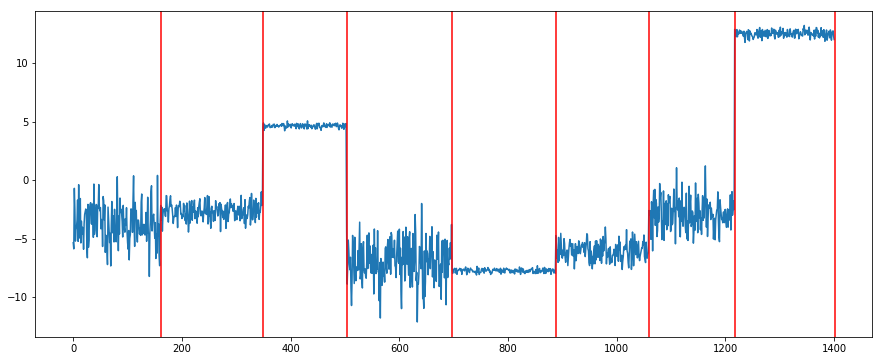

In [121]:
# plot
fig = plt.figure(figsize=(15,6))
plt.plot(dataset_n)
for cp in np.cumsum(part_n):
    plt.axvline(x=cp, color='r')

plt.show()

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


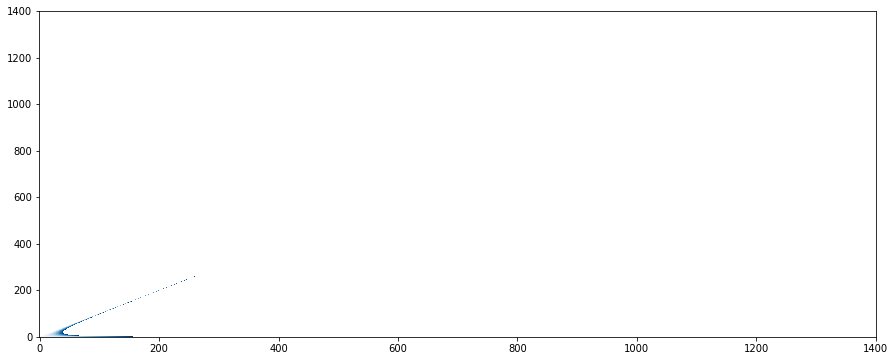

In [133]:
plt.figure(figsize=[15,6])
plt.imshow(-np.log(p), interpolation='none', aspect='auto',origin='lower', cmap=plt.cm.Blues)
plt.show()

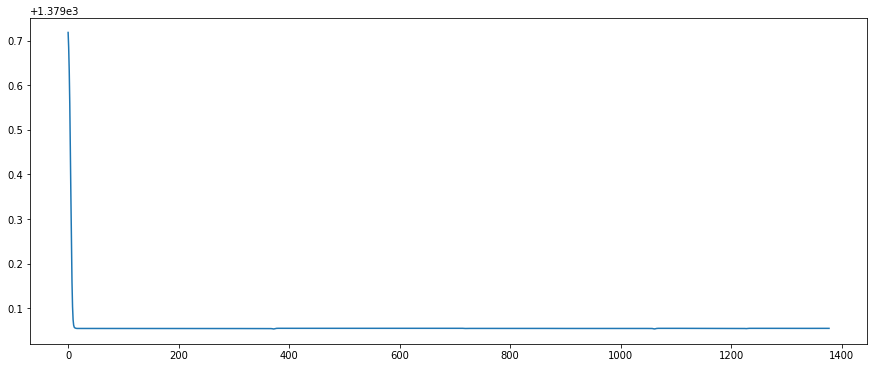

In [116]:
fig = plt.figure(figsize=(15,6))
plt.plot(np.exp(p).sum(0))
plt.show()